# 03 - t-SNE, UMAP, and Clustering

Build low-dimensional embeddings (t-SNE and UMAP) from the processed PCA scores, inspect structure, and persist the results for later clinical association notebooks.


In [1]:
from __future__ import annotations

import sys
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_context("talk")


def find_project_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / "README.md").exists():
            return candidate
    raise FileNotFoundError("Unable to locate repository root (README.md not found)")


PROJECT_ROOT = find_project_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

PROCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed"
PCA_PATH = PROCESSED_DATA_DIR / "tcga_brca_pca_scores.tsv.gz"
PCA_PATH


PosixPath('/Users/lennonmccartney/Desktop/tcga-brca-multiomics-subtyping/data/processed/tcga_brca_pca_scores.tsv.gz')

## Load PCA scores

Use the PCA embedding generated in Notebook 02 as the starting space for downstream manifold learning.


In [2]:
pca_df = pd.read_csv(PCA_PATH, sep="	", index_col=0, compression="gzip")
pca_df.shape

(1197, 50)

In [3]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
ba295155-272e-43eb-9d6a-e4c9c392e68b,66.881381,10.464202,-17.882775,24.450980,-34.534961,12.962275,-5.833964,27.902865,25.287797,-1.656168,...,4.840135,-9.810804,5.326876,-1.743993,10.895772,-1.771303,2.014357,-0.877309,0.184497,-3.534204
8d1641ea-7552-4d23-9298-094e0056386a,32.429013,-9.957598,40.264804,42.590246,-21.292736,55.190396,-33.987849,3.572891,0.974376,20.818672,...,-1.828826,-6.862730,4.830118,-9.513705,6.407914,-6.499774,-4.540029,-2.748677,-3.104844,1.421216
2f51534b-248b-4999-bc3f-e42a2e98332e,-87.738503,39.949205,46.913361,-59.784433,6.412864,-62.221974,-7.556203,22.414156,21.887043,-7.342581,...,7.690612,-6.034682,-29.825285,-0.573876,24.762176,-20.917960,-2.107538,3.631840,-2.675258,8.189914
b321a3f5-043d-42c6-8c9d-5784d45cb85c,58.511724,9.020735,-12.361333,47.892200,76.432903,-41.735964,17.798618,19.477678,13.830445,-26.064546,...,15.193230,3.339026,4.397652,-0.649963,0.078738,8.589395,5.984064,2.373127,4.694300,-4.044868
cafc9e36-c5f0-45df-ad03-16210ff0d870,91.537910,34.798539,-5.758935,18.729015,-18.983191,20.311883,-31.539405,23.071203,5.154782,2.454015,...,13.733020,-3.224252,9.158292,-0.976767,1.603692,-1.013049,-11.823112,-5.078651,10.120465,-7.915902


## t-SNE embedding

Fit t-SNE on the PCA representation (50 dims). Feel free to adjust perplexity/learning rate to taste.


In [4]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=35,
    learning_rate="auto",
    init="pca",
    metric="euclidean",
    random_state=42,
)
tsne_embedding = tsne.fit_transform(pca_df)

tsne_df = pd.DataFrame(tsne_embedding, index=pca_df.index, columns=["tSNE1", "tSNE2"])
tsne_df.head()

,tSNE1,tSNE2
ba295155-272e-43eb-9d6a-e4c9c392e68b,19.154497,-5.283939
8d1641ea-7552-4d23-9298-094e0056386a,10.476553,-9.005371
2f51534b-248b-4999-bc3f-e42a2e98332e,-29.851149,10.312124
b321a3f5-043d-42c6-8c9d-5784d45cb85c,5.417372,-21.869778
cafc9e36-c5f0-45df-ad03-16210ff0d870,26.084085,-12.826666


Text(0, 0.5, 'tSNE2')

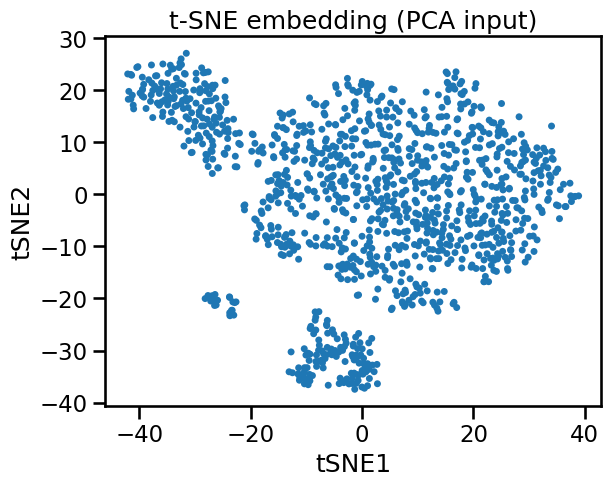

In [5]:
ax = sns.scatterplot(data=tsne_df, x="tSNE1", y="tSNE2", s=25, edgecolor="none")
ax.set_title("t-SNE embedding (PCA input)")
ax.set_xlabel("tSNE1")
ax.set_ylabel("tSNE2")

## UMAP embedding

Reuse the shared `run_umap` helper to produce a 2D UMAP projection from the same PCA space.


In [6]:
from src.dimensionality_reduction import run_umap

umap_df = run_umap(pca_df, n_neighbors=30, min_dist=0.3)
umap_df.head()

/Users/lennonmccartney/Desktop/tcga-brca-multiomics-subtyping/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/lennonmccartney/Desktop/tcga-brca-multiomics-subtyping/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,UMAP1,UMAP2
ba295155-272e-43eb-9d6a-e4c9c392e68b,33.536366,-25.804293
8d1641ea-7552-4d23-9298-094e0056386a,32.513821,-26.534527
2f51534b-248b-4999-bc3f-e42a2e98332e,29.146793,-29.863440
b321a3f5-043d-42c6-8c9d-5784d45cb85c,31.508160,-25.684738
cafc9e36-c5f0-45df-ad03-16210ff0d870,33.925880,-25.519741


Text(0, 0.5, 'UMAP2')

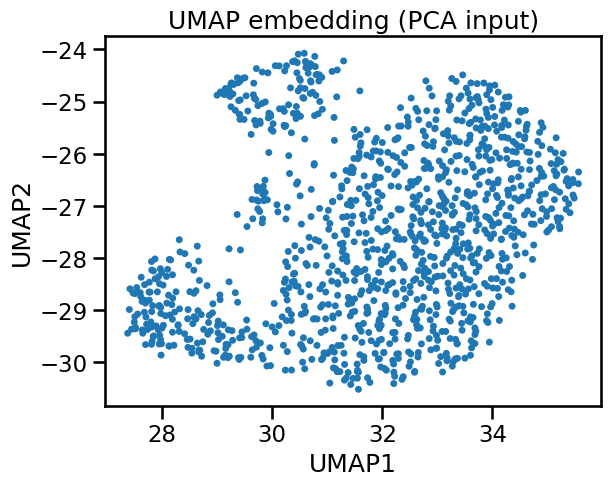

In [7]:
ax = sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", s=25, edgecolor="none")
ax.set_title("UMAP embedding (PCA input)")
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")

## Persist embeddings

Save both embeddings for downstream notebooks that perform clustering and clinical association.


In [8]:
tsne_output = PROCESSED_DATA_DIR / "tcga_brca_tsne.tsv.gz"
umap_output = PROCESSED_DATA_DIR / "tcga_brca_umap.tsv.gz"

tsne_df.to_csv(tsne_output, sep="	", compression="gzip")
umap_df.to_csv(umap_output, sep="	", compression="gzip")

tsne_output, umap_output

(PosixPath('/Users/lennonmccartney/Desktop/tcga-brca-multiomics-subtyping/data/processed/tcga_brca_tsne.tsv.gz'),
 PosixPath('/Users/lennonmccartney/Desktop/tcga-brca-multiomics-subtyping/data/processed/tcga_brca_umap.tsv.gz'))